#### This code is based on https://bit.ly/39LO0jh

In [11]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp

In [12]:
# Global vars
dataset_size = 4898
train_size = int(dataset_size * 0.85)
batch_size = 256
hidden_units = [8,8]
learning_rate = 0.01
num_epochs = 100
sample = 10

In [13]:
def get_splits(train_size, batch_size=1):

    dataset = (
        tfds.load(name="wine_quality", as_supervised=True, split="train")
        .map(lambda x, y: (x, tf.cast(y, tf.float32)))
        .prefetch(buffer_size=dataset_size)
        .cache()
    )

    train_dataset = (
        dataset.take(train_size).shuffle(buffer_size=train_size).batch(batch_size)
    )
    test_dataset = dataset.skip(train_size).batch(batch_size)

    return train_dataset, test_dataset

In [35]:
def run_experiment(model, loss, train_dataset, test_dataset):

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()]
    )

    print("Started training the model...")
    history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)
    print("Finished training the model")
    _, rmse = model.evaluate(train_dataset, verbose=0)
    print(f"The training rms error is {round(rmse, 3)}")
    _, rmse = model.evaluate(test_dataset, verbose=0)
    print(f"The test rms error is {round(rmse, 3)}")

    return history

In [15]:
FEATURE_NAMES = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(1,), dtype=tf.float32
        )
    return inputs

## Point estimate BNN

In [16]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), 
                dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n)
        ]
    )
    return posterior_model

In [17]:
def create_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid"
        )(features)
    
    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
train_dataset, test_dataset = get_splits(train_size, batch_size)
small_train_dataset = train_dataset.unbatch().take(train_size).batch(batch_size)
bnn_model = create_bnn_model(train_size)
mse_loss = keras.losses.MeanSquaredError()
run_experiment(bnn_model, mse_loss, small_train_dataset, test_dataset)

In [19]:
examples, targets = list(test_dataset
.unbatch()
.shuffle(batch_size * 10)
.batch(sample))[0]
def compute_predictions(model, iterations=100):
    predicted = []
    for _ in range(iterations):
        predicted.append(model(examples).numpy())
    predicted = np.concatenate(predicted, axis=1)

    prediction_mean = np.mean(predicted, axis=1).tolist()
    prediction_min = np.min(predicted, axis=1).tolist()
    prediction_max = np.max(predicted, axis=1).tolist()
    prediction_range = (
        np.max(predicted, axis=1) - np.min(predicted, axis=1)
    ).tolist()

    for idx in range(sample):
        print(
        f"Predictions mean: {round(prediction_mean[idx], 2)}, "
        f"min: {round(prediction_min[idx], 2)}, "
        f"max: {round(prediction_max[idx], 2)}, "
        f"range: {round(prediction_range[idx], 2)}, "
        f"Actual: {targets[idx]}" 
        )

compute_predictions(bnn_model)

Predictions mean: 5.31, min: 4.38, max: 5.95, range: 1.57, Actual: 4.0
Predictions mean: 5.34, min: 4.38, max: 6.13, range: 1.75, Actual: 5.0
Predictions mean: 5.37, min: 4.38, max: 6.17, range: 1.79, Actual: 5.0
Predictions mean: 6.28, min: 5.52, max: 6.36, range: 0.84, Actual: 7.0
Predictions mean: 5.78, min: 4.69, max: 6.32, range: 1.63, Actual: 6.0
Predictions mean: 6.17, min: 4.98, max: 6.36, range: 1.37, Actual: 6.0
Predictions mean: 6.07, min: 4.98, max: 6.35, range: 1.37, Actual: 7.0
Predictions mean: 5.74, min: 4.89, max: 6.27, range: 1.38, Actual: 5.0
Predictions mean: 5.99, min: 5.08, max: 6.33, range: 1.25, Actual: 7.0
Predictions mean: 5.37, min: 4.59, max: 6.17, range: 1.58, Actual: 5.0


## Probabilistic BNN

In [28]:
def create_probabilistic_bnn_model(train_size, prior_fn=prior):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior_fn,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid"
        )(features)
    
    distribution_params = layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

num_epochs = 1000
prob_bnn_model = create_probabilistic_bnn_model(train_size)
history = run_experiment(prob_bnn_model, 
negative_loglikelihood, 
train_dataset, 
test_dataset)

In [37]:
prediction_distribution = prob_bnn_model(examples)
prediction_mean = prediction_distribution.mean().numpy().tolist()
prediction_std = prediction_distribution.stddev().numpy()

upper = (prediction_mean + 1.96 * prediction_std).tolist()
lower = (prediction_mean - 1.96 * prediction_std).tolist()
prediction_std = prediction_std.tolist()

for idx in range(sample):
    print(
        f"Prediction mean: {round(prediction_mean[idx][0], 2)}, "
        f"Stddev: {round(prediction_std[idx][0], 2)}, "
        f"95%CI: [{round(lower[idx][0], 2)},{round(upper[idx][0], 2)}]"
        f"Actual: {targets[idx]}"
    )

Prediction mean: 5.31, Stddev: 0.68, 95%CI: [3.97,6.64]Actual: 4.0
Prediction mean: 5.31, Stddev: 0.68, 95%CI: [3.97,6.64]Actual: 5.0
Prediction mean: 5.41, Stddev: 0.69, 95%CI: [4.06,6.77]Actual: 5.0
Prediction mean: 6.24, Stddev: 0.82, 95%CI: [4.63,7.84]Actual: 7.0
Prediction mean: 5.47, Stddev: 0.7, 95%CI: [4.09,6.84]Actual: 6.0
Prediction mean: 6.02, Stddev: 0.78, 95%CI: [4.49,7.55]Actual: 6.0
Prediction mean: 5.61, Stddev: 0.72, 95%CI: [4.2,7.02]Actual: 7.0
Prediction mean: 5.56, Stddev: 0.71, 95%CI: [4.16,6.95]Actual: 5.0
Prediction mean: 5.9, Stddev: 0.76, 95%CI: [4.4,7.4]Actual: 7.0
Prediction mean: 5.33, Stddev: 0.69, 95%CI: [3.99,6.68]Actual: 5.0


Text(0, 0.5, 'RMS error')

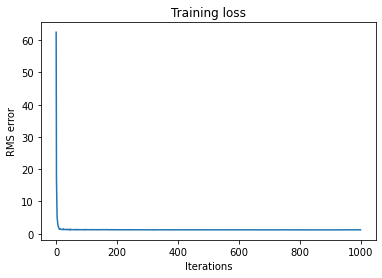

In [39]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Training loss')
plt.xlabel("Iterations")
plt.ylabel("RMS error")

### Logistic regression baseline

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
train_dataset

<BatchDataset element_spec=({'alcohol': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'chlorides': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'citric acid': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'density': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'fixed acidity': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'free sulfur dioxide': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'pH': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'residual sugar': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'sulphates': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'total sulfur dioxide': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'volatile acidity': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [31]:
def trainable_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
        lambda t: tfp.distributions.MultivariateNormalDiag(
            loc=t * tf.ones(n), scale_diag=t * tf.ones(n)
            )
        )
        ]
    )
    return prior_model

In [ ]:
prob_bnn_model_trainable = create_probabilistic_bnn_model(train_size, trainable_prior)
run_experiment(prob_bnn_model_trainable, 
negative_loglikelihood, train_dataset, test_dataset)

In [ ]:
prediction_distribution = prob_bnn_model(examples)
prediction_mean = prediction_distribution.mean().numpy().tolist()
prediction_std = prediction_distribution.stddev().numpy()

upper = (prediction_mean + 1.96 * prediction_std).tolist()
lower = (prediction_mean - 1.96 * prediction_std).tolist()
prediction_std = prediction_std.tolist()

for idx in range(sample):
    print(
        f"Prediction mean: {round(prediction_mean[idx][0], 2)}, "
        f"Stddev: {round(prediction_std[idx][0], 2)}, "
        f"95%CI: [{round(lower[idx][0], 2)},{round(upper[idx][0], 2)}]"
        f"Actual: {targets[idx]}"
    )